We are now implementing the Math class which contains various functions we will be using later on. euclidean_distance, manhattan_distance, chebyshew_distance, knn_predict, normalize, confusion matrix and accuracy are these functions

$$
{\text{Euclidean}}(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$



$$
{\text{Manhattan}}(x, y) = \sum_{i=1}^{n} |x_i - y_i|
$$

$$
{\text{Chebyshev}}(x, y) = \max_{i} |x_i - y_i|
$$

`knn_predict`: Implements the k-nearest neighbors (KNN) algorithm for both classification and regression. Given an input data x, training data x_train, training labels y_train, a number of neighbors k, and a distance function d, it predicts the class (for classification) and the mean value (for regression) of the nearest neighbors for each instance in x<br><br>
`normalize`: Normalizes the data x by subtracting the mean and dividing by the standard deviation along each feature.<br><br>
`confusion_matrix`: Generates a confusion matrix given the true labels y and the predicted labels y_hat. A confusion matrix is a table used to evaluate the performance of a classification model, where the rows represent the true classes and the columns represent the predicted classes.<br><br>
`accuracy`: Calculates the accuracy of the predictions. It compares the true labels y with the predicted labels y_hat and returns the fraction of correct predictions.


In [49]:
from typing import Callable

import numpy as np

In [50]:
class Math:
    @staticmethod
    def euclidean_distance(x: np.ndarray, y: np.ndarray) -> float:
        return np.sqrt(np.sum(np.square(x - y)))

    @staticmethod
    def manhattan_distance(x: np.ndarray, y: np.ndarray) -> float:
        return np.sum(np.abs(x - y))

    @staticmethod
    def chebyshev_distance(x: np.ndarray, y: np.ndarray) -> float:
        return np.max(np.abs(x - y))

    @staticmethod
    def knn_predict(
        x: np.ndarray,
        x_train: np.ndarray,
        y_train: np.ndarray,
        k: int,
        d: Callable[[np.ndarray, np.ndarray], float],
        x_mean: np.ndarray,
        x_std: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray]:
        x_normalized: np.ndarray = Math.normalize(x, x_mean, x_std)
        x_train_normalized: np.ndarray = Math.normalize(x_train, x_mean, x_std)

        y_hat_classification: np.ndarray = np.zeros(len(x_normalized), dtype=int)
        y_hat_regression: np.ndarray = np.zeros(len(x_normalized), dtype=float)

        for i, x_i in enumerate(x_normalized):
            distances = np.array([d(x_i, x_j) for x_j in x_train_normalized])
            nearest_neighbors = np.argsort(distances)[:k]
            nearest_classes = y_train[nearest_neighbors]
            y_hat_classification[i] = np.argmax(np.bincount(nearest_classes))
            y_hat_regression[i] = np.mean(nearest_classes)

        return y_hat_classification, y_hat_regression

    @staticmethod
    def normalize(x: np.ndarray, x_mean: np.ndarray | None = None, x_std: float | None = None) -> np.ndarray:
        """Normalizes the given data."""

        if x_mean is None:
            x_mean = np.mean(x, axis=0)
        if x_std is None:
            x_std = np.std(x, axis=0)

        return (x - x_mean) / x_std

    @staticmethod
    def confusion_matrix(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
        """Returns the confusion matrix of the given data."""
        n_classes = len(np.unique(y))
        matrix = np.zeros((n_classes, n_classes), dtype=int)
        for i in range(len(y)):
            matrix[y[i]][y_hat[i]] += 1
        return matrix

    @staticmethod
    def accuracy(y: np.ndarray, y_hat: np.ndarray) -> float:
        """Returns the accuracy of the given data."""
        return np.mean(y == y_hat)

Next up is the Plot class which we used to visualize our data. The class contains the functions `confusion_matrix`, `accuracies` and `model`.<br><br>
`confusion_matrix`: Visualizes a confusion matrix<br><br>
`accuracies`: Plots the accuracy values for different combinations of k and distance functions<br><br>
`model`: Visualizes the KNN models predictions in a 2D feature space


In [51]:
from matplotlib import pyplot as plt

In [52]:
class Plot:
    """Plots the data."""

    @staticmethod
    def confusion_matrix(
        confusion_matrix: np.ndarray,
        accuracy: float,
        k_used: int | None = None,
        d_used: Callable[[np.ndarray, np.ndarray], float] | None = None,
    ) -> None:
        """Plots the confusion matrix."""

        fig, ax = plt.subplots()

        title = f"Confusion Matrix (k={k_used}, d={d_used.__name__})"
        fig.suptitle(title)
        fig.canvas.manager.set_window_title(title)

        ax.set_title(f"Accuracy: {accuracy * 100:.2f}%")

        im = ax.imshow(confusion_matrix)

        ax.set_xticks(np.arange(confusion_matrix.shape[0]))
        ax.set_yticks(np.arange(confusion_matrix.shape[1]))

        ax.set_xticklabels(np.arange(confusion_matrix.shape[0]))
        ax.set_yticklabels(np.arange(confusion_matrix.shape[1]))

        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                percentage: float = (
                    confusion_matrix[i, j] / np.sum(confusion_matrix[i]) * 100
                )
                ax.text(
                    j,
                    i,
                    f"{confusion_matrix[i, j]} ({percentage:.2f}%)",
                    ha="center",
                    va="center",
                    color="w",
                )

        fig.colorbar(im)
        plt.show()

    @staticmethod
    def accuracies(
        accuracies: dict[tuple[int, Callable[[np.ndarray, np.ndarray], float]], float]
    ) -> None:
        """Plots the accuracies."""

        k_values = set(map(lambda x: x[0], accuracies.keys()))
        d_values = set(map(lambda x: x[1], accuracies.keys()))

        fig, axs = plt.subplots(len(d_values), sharex=True, sharey=True)

        for i, d in enumerate(d_values):
            axs[i].set_title(f"d={d.__name__}")
            axs[i].set_xlabel("k")
            axs[i].set_ylabel("Accuracy")

            x = []
            y = []

            for k in k_values:
                x.append(k)
                y.append(accuracies[(k, d)])

            axs[i].bar(x, y)

        fig.suptitle("Accuracies")
        fig.canvas.manager.set_window_title("Accuracies")

        plt.show()

    @staticmethod
    def model(
        x_predict: np.ndarray,
        y_predict: np.ndarray,
        x_validate: np.ndarray,
        y_validate: np.ndarray,
        k: int,
        d: Callable[[np.ndarray, np.ndarray], float] | None,
        x1_feature_index: int,
        x2_feature_index: int,
        x1_feature_name: str,
        x2_feature_name: str,
    ) -> None:
        """Plots the model."""

        x1_predict = x_predict[:, x1_feature_index]
        x2_predict = x_predict[:, x2_feature_index]
        x_predict_selected = x_predict[:, [x1_feature_index, x2_feature_index]]

        x1_validate = x_validate[:, x1_feature_index]
        x2_validate = x_validate[:, x2_feature_index]

        x1_min, x1_max = (
            min(x1_predict.min(), x1_validate.min()),
            max(x1_predict.max(), x1_validate.max()),
        )
        x2_min, x2_max = (
            min(x2_predict.min(), x2_validate.min()),
            max(x2_predict.max(), x2_validate.max()),
        )

        x1_grid, x2_grid = np.meshgrid(
            np.arange(x1_min - 1, x1_max + 1, 1),
            np.arange(x2_min - 1, x2_max + 1, 1),
        )

        fig, ax = plt.subplots()

        title = f"Model (k={k}, d={d.__name__})"
        fig.suptitle(title)
        fig.canvas.manager.set_window_title(title)

        ax.set_xlabel(x1_feature_name)
        ax.set_ylabel(x2_feature_name)

        x_grid_selected = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))

        x_grid = np.zeros((len(x_grid_selected), x_predict.shape[1]))
        x_grid[:, [x1_feature_index, x2_feature_index]] = x_grid_selected
        for i in range(x_predict.shape[1]):
            if i != x1_feature_index and i != x2_feature_index:
                x_grid[:, i] = np.mean(x_predict[:, i])

        # y_hat_selected, _ = Math.knn_predict(x_grid, x_predict, y_predict, k, d)
        x_mean = np.mean(x_predict_selected, axis=0)
        x_std = np.std(x_predict_selected, axis=0)
        y_hat_selected, _ = Math.knn_predict(
            x_grid_selected, x_predict_selected, y_predict, k, d, x_mean, x_std
        )

        plt.pcolormesh(
            x1_grid,
            x2_grid,
            y_hat_selected.reshape(x1_grid.shape),
            cmap="viridis",
            shading="auto",
        )
        plt.scatter(
            x1_validate[:20],
            x2_validate[:20],
            c=y_validate[:20],
            s=50,
            cmap="viridis",
            marker="^",
            edgecolor="black",
        )
        plt.scatter(
            x1_predict[:40],
            x2_predict[:40],
            c=y_predict[:40],
            s=50,
            cmap="viridis",
            edgecolor="black",
        )

        plt.show()

Now we are implementing the `KnnClassifier` class which uses the math and plot class we implemented earlier.<br><br>
`__init__`: initializes the model and sets deafult k-values and distance functions if they are not provided.<br><br>
`fit`: determines the optimal values for k and the distance function by iterating over all combinations and choosing the pair that gives the highest accuracy on the validation set.<br><br>
`predict`: Predicts class labels for a given input data set. When no specific k or distance function is provided. it uses the optimal values determined during training.<br><br>
`visualize_model`: Visualizes the KNNs model classification in a 2D space
<br><br>
`visualize_optimal`: visualizes the result after training is done.<br><br>
`visualize_all`: Visualizes the results for all combinations of l and distance functions.

In [53]:
from itertools import product

In [54]:
D_VALUES_DEFAULT: set[Callable[[np.ndarray, np.ndarray], float]] = {
    Math.euclidean_distance,
    Math.manhattan_distance,
    Math.chebyshev_distance,
}

K_VALUES_DEFAULT: set[int] = set(range(1, 10))


class KnnClassifier:
    k_values: list[int]
    d_values: list[Callable[[np.ndarray, np.ndarray], float]]
    is_trained: bool
    k_optimal: int
    d_optimal: Callable[[np.ndarray, np.ndarray], float]
    x_predict: np.ndarray
    y_predict: np.ndarray
    x_mean: np.ndarray
    x_std: float

    def __init__(
        self,
        k_values: set[int] = K_VALUES_DEFAULT,
        d_values: set[Callable[[np.ndarray, np.ndarray], float]] = D_VALUES_DEFAULT,
    ):
        """Initializes the model."""

        self.k_values = list(k_values)
        self.d_values = list(d_values)
        self.is_trained = False
        self.k_optimal = self.k_values[0]
        self.d_optimal = self.d_values[0]

    def fit(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_validation: np.ndarray,
        y_validation: np.ndarray,
    ) -> None:
        """Fits the model to the training data and finds the optimal k and d values."""

        accuracy_optimal: float = 0.0
        self.x_mean = np.mean(x_train, axis=0)
        self.x_std = np.std(x_train, axis=0)

        for k, d in product(self.k_values, self.d_values):
            y_hat_validation, _ = Math.knn_predict(x_validation, x_train, y_train, k, d, self.x_mean, self.x_std)
            accuracy = Math.accuracy(y_validation, y_hat_validation)

            if accuracy > accuracy_optimal:
                accuracy_optimal = accuracy
                self.k_optimal = k
                self.d_optimal = d

        self.x_predict = x_train
        self.y_predict = y_train
        
        self.is_trained = True

    def predict(
        self,
        x: np.ndarray,
        x_predict: np.ndarray | None = None,
        y_predict: np.ndarray | None = None,
        k: int | None = None,
        d: Callable[[np.ndarray, np.ndarray], float] | None = None,
    ) -> tuple[np.ndarray, np.ndarray]:
        """Predicts the class of the given data."""

        if not self.is_trained:
            raise Exception("Model must be trained before predicting.")

        if k is None:
            k = self.k_optimal

        if d is None:
            d = self.d_optimal

        if x_predict is None:
            x_predict = self.x_predict

        if y_predict is None:
            y_predict = self.y_predict

        return Math.knn_predict(x, x_predict, y_predict, k, d, self.x_mean, self.x_std)

    def visualize_model(
        self,
        x_validate: np.ndarray,
        y_validate: np.ndarray,
        x1_feature_index: int,
        x2_feature_index: int,
        x1_feature_name: str,
        x2_feature_name: str,
    ) -> None:
        """Visualize the models classification behaviour."""

        Plot.model(
            self.x_predict,
            self.y_predict,
            x_validate,
            y_validate,
            self.k_optimal,
            self.d_optimal,
            x1_feature_index,
            x2_feature_index,
            x1_feature_name,
            x2_feature_name,
        )

    def visualize_optimal(self, x: np.ndarray, y: np.ndarray) -> None:
        """Visualize the results for the optimal k and d values."""

        if not self.is_trained:
            raise Exception("Model must be trained before visualizing.")

        y_hat, _ = self.predict(x)

        confusion_matrix = Math.confusion_matrix(y, y_hat)
        accuracy = Math.accuracy(y, y_hat)

        Plot.confusion_matrix(
            confusion_matrix, accuracy, self.k_optimal, self.d_optimal
        )

    def visualize_all(self, x: np.ndarray, y: np.ndarray) -> None:
        """Visualize the results for all k and d values."""

        if not self.is_trained:
            raise Exception("Model must be trained before visualizing.")

        accuracies: dict[
            tuple[int, Callable[[np.ndarray, np.ndarray], float]], float
        ] = {}

        for k, d in product(self.k_values, self.d_values):
            y_hat, _ = self.predict(x, k=k, d=d)
            accuracy = Math.accuracy(y, y_hat)
            accuracies[(k, d)] = accuracy

        Plot.accuracies(accuracies)

Lastly everything is coming together in main.

In [55]:
import pandas as pd

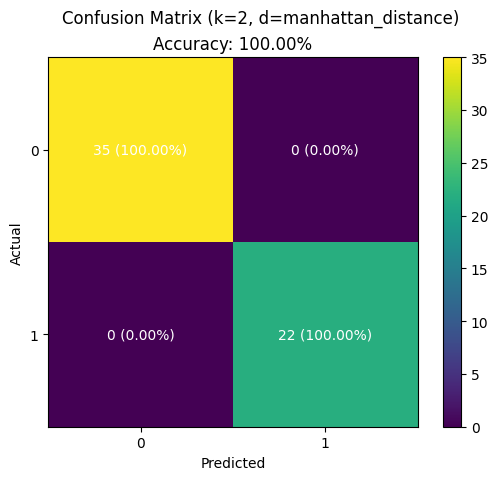

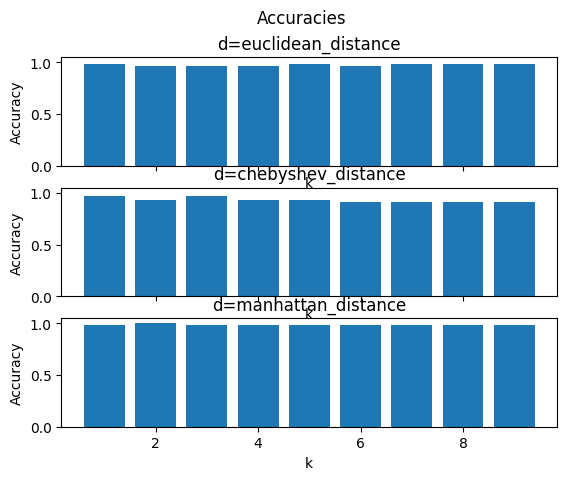

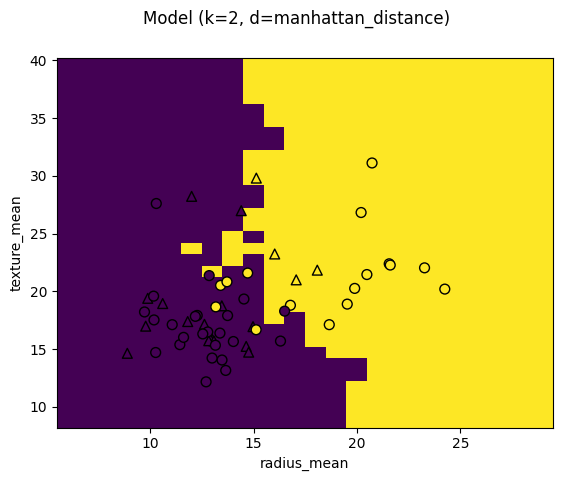

In [56]:

def main() -> None:
    DATA_PATH: str = "../data.csv"
    TRAIN_VALIDATION_TEST_SPLIT = (0.7, 0.2, 0.1)

    dataframe: pd.DataFrame = pd.read_csv(DATA_PATH)
    data: np.ndarray = dataframe.to_numpy()

    np.random.shuffle(data)

    n: int = len(data)
    train, validation, test = np.split(
        data,
        [
            int(TRAIN_VALIDATION_TEST_SPLIT[0] * n),
            int((TRAIN_VALIDATION_TEST_SPLIT[0] + TRAIN_VALIDATION_TEST_SPLIT[1]) * n),
        ],
    )

    

    x_train: np.ndarray = train[:, 1:]
    y_train: np.ndarray = train[:, 0].astype(int)

    x_validate: np.ndarray = validation[:, 1:]
    y_validate: np.ndarray = validation[:, 0].astype(int)

    x_test: np.ndarray = test[:, 1:]
    y_test: np.ndarray = test[:, 0].astype(int)

    knn_classifier = KnnClassifier()

    knn_classifier.fit(x_train, y_train, x_validate, y_validate)

    _ = knn_classifier.predict(x_test)

    knn_classifier.visualize_optimal(x_test, y_test)
    knn_classifier.visualize_all(x_test, y_test)

    x1_label = dataframe.columns[1]
    x2_label = dataframe.columns[2]

    

    knn_classifier.visualize_model(x_validate, y_validate, 0, 1, x1_label, x2_label)


if __name__ == "__main__":
    main()